## Sim-Telco
### Or how to guess where cell towers should go, given where people are 

This notebook describes a simple algorithm to place realistic but synthetic cell tower sites in a country and to creat realistic flows between them based on the [Gravity Model](https://en.wikipedia.org/wiki/Gravity_model_of_migration). I'm super interested in the utility of [synthetic data](https://medium.com/@alexRutherford/fake-real-data-or-real-fake-data-eb6622d2ab2e#.3ectnv6vs)

The algorithm was developed in partner with [Manuel Garcia-Herranz](https://twitter.com/Ranzher) at [UNICEF Innovation Unit](http://www.unicef.org/innovation/)

Shapefile data comes from [GADM](gadm.org) and population data comes from [World Pop](worldpop.org)

In [91]:
import sys,csv
sys.path.append('/usr/local/lib/python2.7/dist-packages/')
import matplotlib.pyplot as plt
import shapefile,pickle,random,re,collections
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.path as mplPath

#from matplotlib.collections import PatchCollection
import seaborn as sns
%matplotlib inline

In [36]:
sns.set_context('notebook')
sns.set_style('white',rc={'grid':'black'})
%config InlineBackend.figure_format='svg'

In [61]:
def setFigSize(dim=(16.5,5.5)):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(dim[0],dim[1])

In [28]:
sf = shapefile.Reader("BRA_adm0.shp")
shapes=sf.shapes()

In [31]:
paths=collections.defaultdict(list)

for nshp in xrange(len(shapes)):
    pts     = np.array(shapes[nshp].points)
    prt     = shapes[nshp].parts
    par     = list(prt) + [pts.shape[0]]
    for pij in xrange(len(prt)):
        paths[nshp].append(mplPath.Path(pts[par[pij]:par[pij+1]]))

Downsample the data using GDAL. This subsamples by taking the mean, meaning each pixel must later be multiplied by 16

``gdal_translate -outsize 25% 25% BRA_ppp_v2b_2015.tif BRA_ppp_v2b_2015_25.tif``

Then convert into plain text

``gdal_translate -of AAIGrid BRA_pph_v2b_2015.tif  out.asc``

Then set no data values (outside of the country) to zero

``sed '\s\-3.4028234663853e+38\0\g' ``

In [6]:
!head -n 7 BRA_ppp_25_nd.asc

ncols        13547
nrows        11707
xllcorner    -73.991778925517
yllcorner    -33.752706552680
dx           0.003333261512
dy           0.003333413539
NODATA_value  0


In [9]:
headerFile=csv.reader(open('BRA_ppp_25_nd.asc','r'))

lines=[headerFile.next()[0] for i in range(7)]

numbers=re.findall(r'[0-9\.\-]{2,}',' '.join(lines))
words=re.findall(r'[a-zA-Z]{2,}',' '.join(lines))

In [160]:
nCols,nRows,x0,y0,xSize,ySize=map(float,numbers)

In [3]:
%time a=np.loadtxt('BRA_ppp_25_nd.asc',skiprows=7)
a*=16.

CPU times: user 23min 43s, sys: 12 s, total: 23min 55s
Wall time: 24min 2s


Set up some convenience functions to translate from matrix indices to latitude and longitude. THe origin is defined as the top left corner in this case.

In [162]:
def getLatLong(xy):
    x=xy[1]
    y=xy[0]
    return (x0+(x*ySize),y0+((nRows-y)*xSize))

In [14]:
def calculatePop(a,p1,p2):
    res=np.sum(a[p1[0]:p2[0],p1[1]:p2[1]])
    return res

In [33]:
def inCountry(tower):
    return True
    point,guess=testPoint(tower,None)
    if not point==None:
        return True
    else:
        return False

The placement of towers balances two objectives: all towers should cover as close as possible to a common value of people. If too many people use the tower it is over-capacity and put under a lot of strain, if too few then the tower wastes resources as it must be maintained and powered.

The high level logic of the algorithm is to take an array of populations, to recursively split the array into ``N`` parts until either (i) the population in those parts are small enough to be covered by a single tower or the parts are of a low population that a tower cannot be justified. The key parameters of the model are the **range of each tower**, the **target population to be covered by each tower** and into **how many slices the array should be split**.

In [16]:
def newTower(p1,p2):
    newTower = (p1[0]+random.random()*(p2[0]-p1[0]),p1[1]+random.random()*(p2[1]-p1[1]))
    while not inCountry(newTower):
         newTower = (p1[0]+random.random()*(p2[0]-p1[0]),p1[1]+random.random()*(p2[1]-p1[1]))
    return newTower

In [115]:
towerRange = 50
# How many pixels can a tower cover e.g. 400m=1 cell, towerRange=50 => 20km
pthr=10000
# How many people can be covered by tower (larger => fewer towers)
N=2
# How to split cells

minD=1
# This should max single pixel value in pop array
# Min distance between towers (lowest value can be 1)

In [18]:
def assignTowers(a,p1,p2,towers,populations,it,verbose=False):
    if verbose:
        print it
    
    assert p1[0]<p2[0]
    assert p1[1]<p2[1]
    
    dP = (p2[0]-p1[0])
    dPn = dP/N
    pop = calculatePop(a,p1,p2)
        
    if ((pop > pthr) and (dPn > minD)):        
        for i in range(N):
            for j in range(1,N+1):
                towers = assignTowers(a,(p1[0]+(i*dPn),p1[1]+((j-1)*dPn)),(p1[0]+((i+1)*dPn),p1[1]+(j*dPn)),\
                                      towers,populations,it+1,verbose=False)
    else:
        numT = pop/pthr
        for i in range(int(numT)):
            towers.append(newTower(p1,p2))
            populations.append(pop/float(numT))
            numT=numT-1
        
        if numT**10 > random.random():
            # We want to aggresively reduce the probability that low populations get a tower
            towers.append(newTower(p1,p2))
            populations.append(pop*numT)

    return towers

In [20]:
def getTowers(a):
    
    towers = []
    populations=[]
    p1=(0,0)
    
    while p1[0]<a.shape[0]:
        
        p1=(p1[0],0)
        while p1[1]<a.shape[1]:
            towers=assignTowers(a,p1,(p1[0]+towerRange,p1[1]+towerRange),towers,populations,0,verbose=False)
            p1=(p1[0],p1[1]+towerRange)
        p1=(p1[0]+towerRange,p1[1])
    return towers,populations

In [22]:
def testPoint(point,guess):
    '''
    Takes (x,y) tuple and returns index of voronoi, if hit is detected
    '''
    if guess:
        for p in paths[guess]:
            if p.contains_point(point):
                return guess,guess
    
    for nshp in xrange(len(shapes)):
        for p in paths[nshp]:
            if p.contains_point(point):
                return nshp,nshp
    
    return None,None

In [116]:
%time towersOut,populationOut=getTowers(a)
print len(towersOut),len(populationOut)

CPU times: user 2.93 s, sys: 0 ns, total: 2.93 s
Wall time: 2.93 s
3448 3448


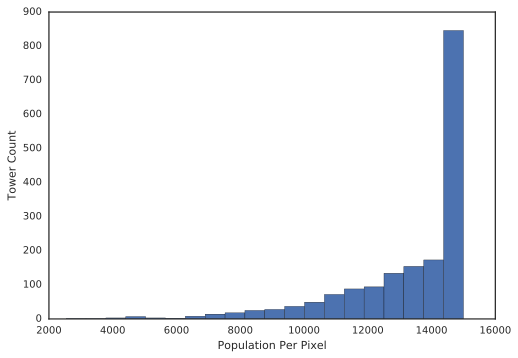

In [88]:
_=plt.hist(populationOut,log=False,bins=20)
plt.xlabel('Population Per Pixel')
plt.ylabel('Tower Count')

In [39]:
towersOut[0:5]

[(717.4477151872271, 3985.9561348676943),
 (1589.3147528643328, 6847.00436751696),
 (1567.4731457512528, 6882.921040697577),
 (1580.919391901093, 6869.74541240458),
 (1913.2666642330105, 7902.916183802005)]

In [163]:
latsLongs=map(getLatLong,towersOut)

In [164]:
towerLatLongs=np.array(latsLongs)

A quick plot in a small region of towers along with their ranges on top of the raw population

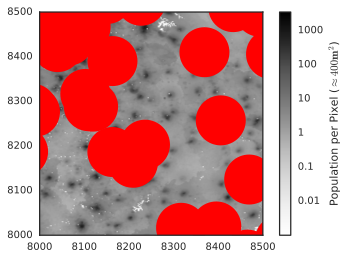

In [119]:
plt.imshow(np.log(0.001+a))
plt.plot([t[1] for t in towersOut],[t[0] for t in towersOut],'.',alpha=0.25,markersize=towerRange*2,color='red')

cbar=plt.colorbar(ticks=map(np.log,[0.01,0.1,1,10,100,1000]))

_=cbar.ax.set_yticklabels([0.01,0.1,1,10,100,1000]) 
cbar.set_label(r'Population per Pixel ($\approx \bf{400m}^{2}$)')

plt.xlim(8000,8500)
plt.ylim(8000,8500)

plt.savefig('map_inset.png',dpi=300)

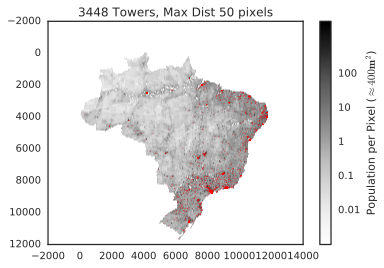

In [120]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1) 

plt.imshow(np.log(0.001+a))

plt.title('%d Towers, Max Dist %d pixels' %(len(towersOut),towerRange))

plt.plot([t[1] for t in towersOut],[t[0] for t in towersOut],'.',alpha=0.5,markersize=1.5,color='red')

cbar=plt.colorbar(ticks=map(np.log,[0.01,0.1,1,10,100]))
_=cbar.ax.set_yticklabels([0.01,0.1,1,10,100]) 
cbar.set_label(r'Population per Pixel ($\approx \bf{400m}^{2}$)')
plt.savefig('map.png',dpi=300)

### Get real towers from [here](http://braziltowercompany.com/en/sites-locations.html)

In [54]:
realTowers=pd.read_csv('BTC_Sites_Details_2016-01-31.csv',sep=',')

In [55]:
realTowers.head()

,NAME,TOWER HEIGHT,SITE CODE,AEV,LATITUDE,LONGITUDE,UF,CITY,STATUS
0,NaN,0,BTC-1045,0,-12.8653,-42.2034,BA,NaN,AGUARDA NOVO PN
1,NaN,0,BTC-1046,0,-14.8550,-40.0509,BA,NaN,RFI
2,NaN,0,BTC-1047,0,-13.4235,-42.5858,BA,NaN,RFI
3,NaN,0,BTC-1048,0,-16.3616,-39.9708,BA,NaN,RFI
4,NaN,0,BTC-1049,0,-12.0690,-42.4580,BA,NaN,NOVA BUSCA


In [56]:
realTowers.shape

(730, 9)

In [57]:
towerLatLongs.shape

(728, 2)

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(111)

for nshp in range(len(shapes)):
    print nshp
    ptchs=[]
    pts=np.array(shapes[nshp].points)
    prt=shapes[nshp].parts
    par=list(prt)+[pts.shape[0]]
    for pij in range(len(prt)):
        plt.plot(pts[par[pij:0]],par[pij+1:1])
        ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))
        
    ax.add_collection(PatchCollection(ptchs,color='none',edgecolor='black'))
plt.ylim(sf.bbox[0],sf.bbox[1])
plt.xlim(sf.bbox[2],sf.bbox[3])

(-28.846944808959982, 5.264877796173096)

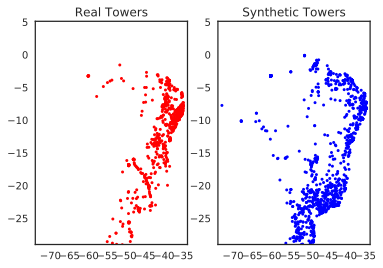

In [166]:
plt.subplot(1, 2, 1)
plt.plot(realTowers.LONGITUDE,realTowers.LATITUDE, '.',alpha=0.3,markersize=6,color='red')
plt.title('Real Towers')
plt.xlim(sf.bbox[0],sf.bbox[1])
plt.ylim(sf.bbox[2],sf.bbox[3])

plt.subplot(1, 2, 2)
plt.plot(towerLatLongs[:,0],towerLatLongs[:,1], '.',alpha=0.3,markersize=6,color='blue')
plt.title('Synthetic Towers')
plt.xlim(sf.bbox[0],sf.bbox[1])
plt.ylim(sf.bbox[2],sf.bbox[3])

In [ ]:
n=0
plt.plot([px[0] for px in shapes[n].points],[px[1] \
                                                for px in shapes[n].points[0:1000]],'k.',ms=2)

In [ ]:
import folium
map_osm = folium.Map(location=shapes[0].)

### Gravity Model

In [125]:
# From http://www.johndcook.com/blog/python_longitude_latitude/
earthRadius=6371.0
# KMs

def distance(lat1, long1, lat2, long2):
    '''
    latitude is north-south
    '''
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc*earthRadius


In [ ]:
d=np.zeros(shape=(len(towersOut),len(towersOut)))
longVals=towerLatLongs[:,0]
latVals=towerLatLongs[:,1]

for ni in range(len(longVals)):
    for nj in range(len(latVals)):
        if not ni==nj:
            try:
                d[ni,nj]=utils.distance(latVals[ni],longVals[ni],latVals[nj],longVals[nj])
            except:
                print ni,nj